In [1]:
import sys
sys.path.append("../src/")
import pickle
import numpy as np
import pandas as pd
from collections import Counter
import gensim
import seaborn as sns
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.manifold import MDS
from sklearn import manifold
from sklearn.metrics import roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.base import clone

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import time
import pickle
import pandas as pd
import numpy as np

from keras.callbacks import LambdaCallback

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from model_utils import *

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


In [9]:
maxlen_word = 20
maxlen_sentence = 300
main_path = '../final_data/'
train_data_path = main_path + 'train_data_from_1728.pickle'
test_data_path = main_path + 'test_data_from_1728.pickle'

f = open(train_data_path, 'rb')
train_data = pickle.load(f)
f.close()

f = open(test_data_path, 'rb')
test_data = pickle.load(f)
f.close()
w2v_path = main_path+'w2v_model_6dim_from_1200_seu.model'


x_train, y_train, input_dim, class_num = data_process(train_data, feature=1, w2v_path=w2v_path,split_data=False)
x_test, y_test, input_dim, class_num = data_process(test_data, feature=1, w2v_path=w2v_path,split_data=False)

input_dim 6
input_dim 6


In [10]:
print(x_train.shape)
print(x_test.shape)

(1025, 300, 20, 6)
(257, 300, 20, 6)


In [12]:
model = get_simple_HAN_model(maxlen_sentence, maxlen_word, class_num, index_test=False, input_dim=input_dim)
model.load_weights(main_path+'HAN_model_from_1728.h5')
model.evaluate(x_test, y_test)

257/257 [==============================] - 2s 7ms/sample - loss: 0.5341 - accuracy: 0.9300


[0.5340780928325096, 0.9299611]

In [13]:
# true label
y_true=np.argmax(y_test,axis=-1).copy()
np.unique(y_true)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [14]:
# predict label
y_pred=model.predict(x_test)
# y_pred

In [15]:
roc_dict={}

for k in range(len(np.unique(y_true))):
    temp_roc_dict={}
    y_test_tmp=y_true.copy()
    index_false=np.squeeze(np.argwhere(y_test_tmp!=k))
    y_test_tmp[index_false]=-1
    y_pred_tmp = y_pred[:,k].copy()
#     print(k,"\n",y_pred_tmp,y_test_tmp)
#     print("===============")
    fpr, tpr, thresholds = roc_curve(y_test_tmp, y_pred_tmp, pos_label=k, drop_intermediate=False)
    auc = metrics.auc(fpr, tpr)
#     print(k,"\n",fpr,tpr)
#     print("===============")
    temp_roc_dict["fpr"]=(fpr)
    temp_roc_dict["tpr"]=(tpr)
    temp_roc_dict["thresholds"]=(thresholds)
    temp_roc_dict["auc"]=round(auc,2)
    roc_dict[k] = temp_roc_dict

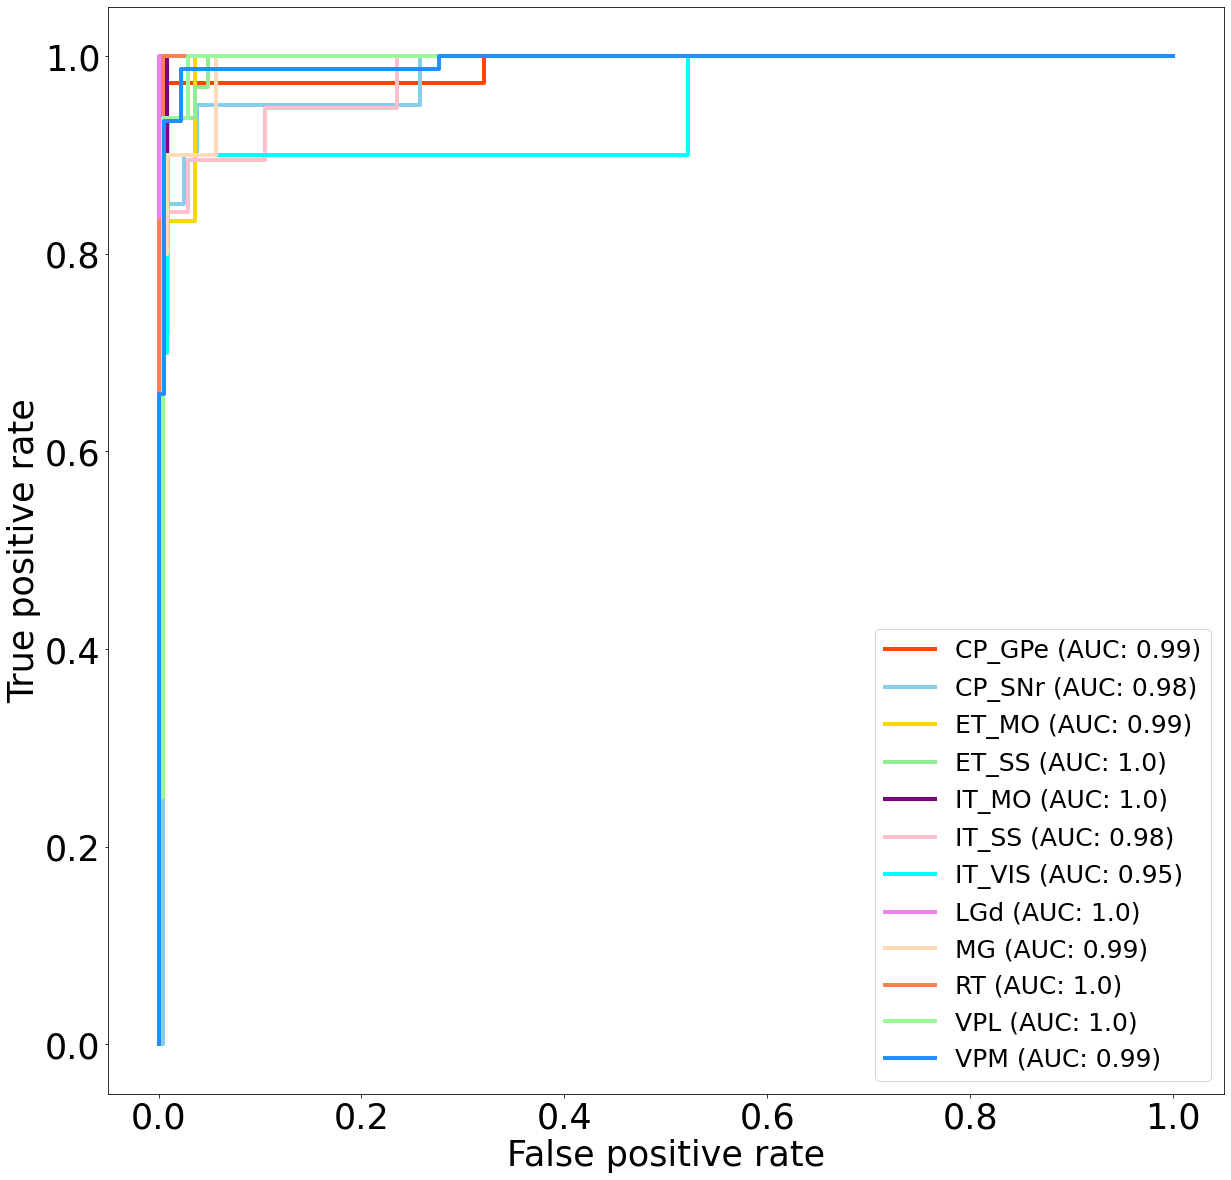

In [16]:
plt.figure(figsize=(20,20))
label_num_dict={0:'CP_GPe',1:'CP_SNr', 2:'ET_MO', 3:'ET_SS', 4:'IT_MO',5:"IT_SS",6:'IT_VIS',7:'LGd',8:'MG',9:'RT',10:'VPL',11:'VPM'}
colors={0:'orangered',1:'skyblue',2:'gold',3:'lightgreen',4:'purple',5:'pink',6:'cyan',7:'violet',8:'peachpuff',9:'coral',10:'palegreen',11:'dodgerblue'}
for k in range(len(np.unique(y_true))):
    plt.plot(roc_dict[k]["fpr"],roc_dict[k]["tpr"],c=colors[k],linewidth=4,label=label_num_dict[k]+" (AUC: "+str(roc_dict[k]["auc"])+")")
plt.xticks(fontsize=35)
plt.xlabel("False positive rate", fontsize=35)
plt.yticks(fontsize=35)
plt.ylabel("True positive rate", fontsize=35)
plt.legend(fontsize=25)
# plt.title('ROC',fontsize=30)
# plt.savefig(r'roc.png',dpi=200)